In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

data = pd.read_csv("meteo_data_30.csv")
#data = data.drop(data.index[:12995])
data
#data.to_csv('week.csv')

,SOLAR_RADIATION,PRECIPITATION,WIND_SPEED,LEAF_WETNESS,HC_AIR_TEMPERATURE,HC_RELATIVE_HUMIDITY,DEW_POINT,Date
0,118.0,0.0,2.4,0.0,10.03,100.00,9.9,2024-03-15 17:00:00
1,43.0,0.0,2.8,0.0,9.71,75.00,0.0,2024-03-15 18:00:00
2,0.0,0.0,2.4,0.0,9.01,91.66,0.0,2024-03-15 19:00:00
3,0.0,0.2,2.5,0.0,8.51,100.00,8.4,2024-03-15 20:00:00
4,0.0,0.0,2.5,0.0,7.89,100.00,7.8,2024-03-15 21:00:00
...,...,...,...,...,...,...,...,...
714,659.0,0.0,2.5,0.0,18.10,82.03,14.8,2024-04-14 12:00:00
715,616.0,0.0,2.1,0.0,19.15,76.75,0.0,2024-04-14 13:00:00
716,262.0,0.0,1.9,0.0,18.37,52.53,0.0,2024-04-14 14:00:00
717,230.0,0.0,1.5,0.0,18.10,73.00,0.0,2024-04-14 15:00:00


In [23]:
data = data.drop(data.columns[4], axis=1)
data = data.drop(data.columns[6], axis=1)
data

,SOLAR_RADIATION,PRECIPITATION,WIND_SPEED,LEAF_WETNESS,HC_RELATIVE_HUMIDITY,DEW_POINT
0,118.0,0.0,2.4,0.0,100.00,9.9
1,43.0,0.0,2.8,0.0,75.00,0.0
2,0.0,0.0,2.4,0.0,91.66,0.0
3,0.0,0.2,2.5,0.0,100.00,8.4
4,0.0,0.0,2.5,0.0,100.00,7.8
...,...,...,...,...,...,...
714,659.0,0.0,2.5,0.0,82.03,14.8
715,616.0,0.0,2.1,0.0,76.75,0.0
716,262.0,0.0,1.9,0.0,52.53,0.0
717,230.0,0.0,1.5,0.0,73.00,0.0


In [24]:
# Преобразование данных в массив numpy
dataset = data.values

# Масштабирование данных (нормализация)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [25]:
# Подготовка данных для LSTM модели
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, 4])  # Возьмем первый столбец (SOLAR_RADIATION) в качестве целевой переменной
    return np.array(X), np.array(y)

sequence_length = 24  # Длина последовательности, например, на 24 часа
X, y = create_sequences(scaled_data, sequence_length)

# Разделение данных на обучающий и тестовый наборы
train_size = int(len(X) * 0.8)  # 70% данных используется для обучения
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [26]:
# Создание и компиляция LSTM модели
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mse')

# Обучение модели
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Оценка модели на тестовом наборе данных
mse = model.evaluate(X_test, y_test)
print('Mean Squared Error on Test Set:', mse)

# Предсказание на тестовом наборе данных
y_pred = model.predict(X_test)

# Вычисление коэффициента детерминации
r2 = r2_score(y_test, y_pred)
print('R^2 Score on Test Set:', r2)

Epoch 1/50


C:\Users\Счастливый Наиль\PycharmProjects\meteoApp\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0708 - val_loss: 0.0465
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0469 - val_loss: 0.0526
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0473 - val_loss: 0.0589
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0423 - val_loss: 0.0508
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0403 - val_loss: 0.0517
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0386 - val_loss: 0.0586
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0306 - val_loss: 0.0627
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0400 - val_loss: 0.0513
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0327 - val_loss: 0.0529
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0289 - val_loss: 0.0541
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0266 - val_loss: 0.0508
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0256 - val_l

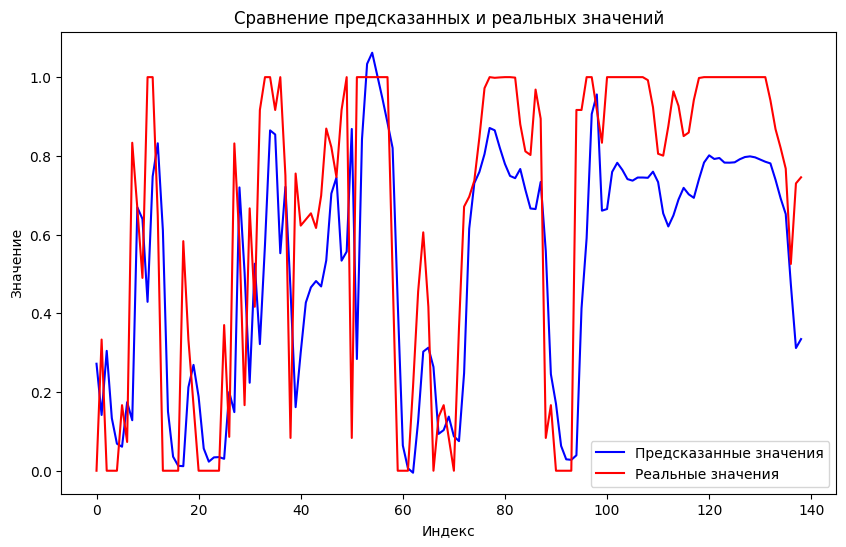

In [27]:
# Построение графика предсказаний и реальных значений
plt.figure(figsize=(10, 6))

# Построение линии для предсказанных значений
plt.plot(y_pred, label='Предсказанные значения', color='blue')

# Построение линии для реальных значений
plt.plot(y_test, label='Реальные значения', color='red')

# Настройка графика
plt.title('Сравнение предсказанных и реальных значений')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()

# Показать график
plt.show()